In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_rows', 100)


In [112]:
df = pd.read_csv('QueryResults2.csv')
display(df[:5])
print("Shape of Df:",  df.shape)

Title  \
0  Android Jetpack Navigation, BottomNavigationVi...   
1               JetPack Compose Button with drawable   
2  How to handle back button when at the starting...   
3  TopAppBar flashing when navigating with Compos...   
4    How to create recycler view in Compose Jetpack?   

                                                Body  \
0  <p>Android Jetpack Navigation, BottomNavigatio...   
1  <p>How can we achieve this in jetpack compose<...   
2  <p>I've started working with the new navigatio...   
3  <p>I have 2 screens which both have their own ...   
4  <p>Is there any special way to create recycler...   

                                                Tags        Id  Score  \
0  <android><android-architecture-components><bot...  50577356     81   
1  <android><android-jetpack-compose><android-com...  72336943     10   
2  <android-architecture-components><android-arch...  50937116     17   
3  <android><android-jetpack><android-jetpack-com...  68633717     19   
4  <android><android-recyclerview><android-jetpac...  58691725     17   

   ViewCount  AnswerCount  
0      67388           14  
1      17903            6  
2      23616            8  
3       4757            9  
4      12553            7

Shape of Df: (50000, 7)


<Axes: >

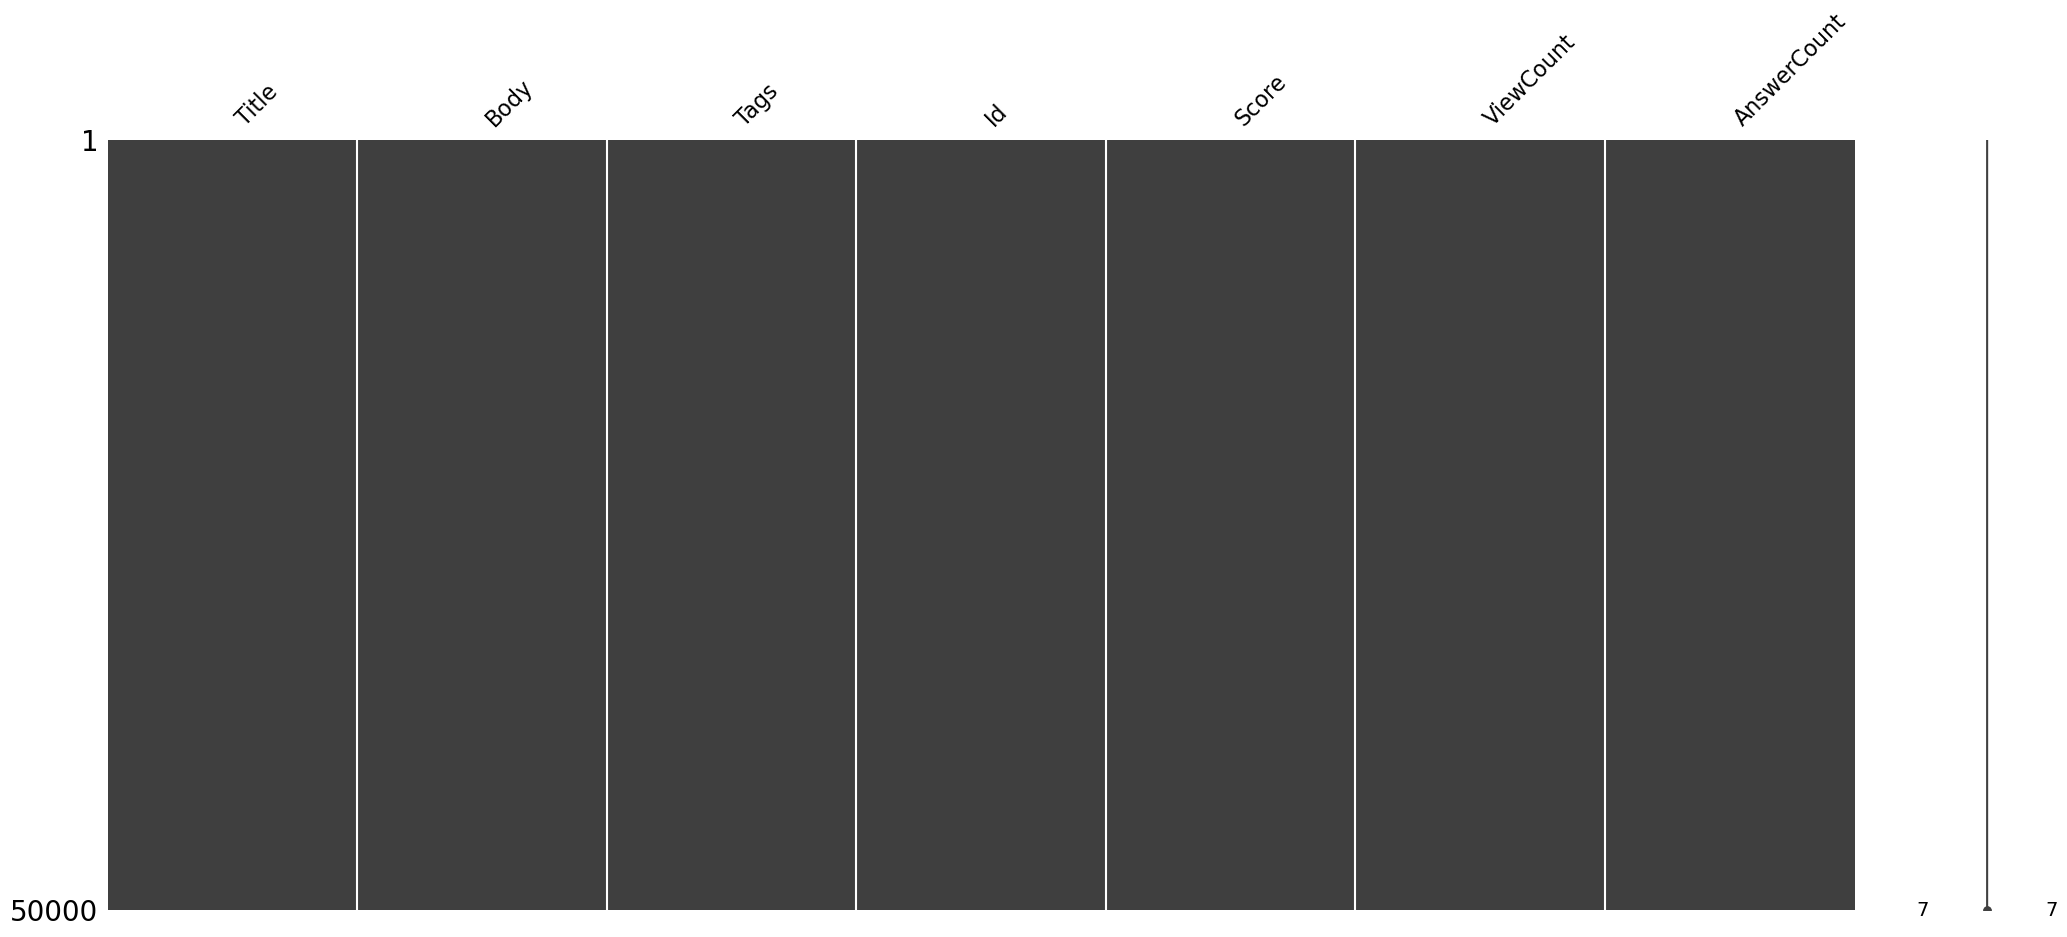

In [113]:
msno.matrix(df)

### Pipeline preprocessing

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


class TagsCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_tags(text) for text in X]

    def clean_tags(self, text):
        tags_to_transform = BeautifulSoup(text, "html.parser")
        return [tag.name for tag in tags_to_transform.find_all()]
    
    
class HtmlCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [self.clean_text(text) for text in X]

    def clean_text(self, text):
    # Delete HTML tags
        clean_text = re.sub(r'<.*?>', '', text)
    # Delete special characters and punctuation
        clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text)
        return clean_text
    

class TextTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [nltk.word_tokenize(text) for text in X]

class TextLower(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[word.lower() for word in text] for text in X]
    
class TextStopWordRemover(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        stop_words = set(nltk.corpus.stopwords.words('english'))
        additional_stopwords = {"im", "ive",'new','like','get','want','would','need','use','using','used','one','two','three','four','five','six','seven','eight','nine','ten',
                                'public','like', 'doesnt','try','thanks',
                                'microsoftextensionsdependencyinjectionactivatorutilitiesgetserviceorcreateinstanceiserviceprovider',
                                'uscentraldockerpkgdevprojectidreponamev','use','gt','orgopenqaseleniuminteractionsactionsbuiltactionperformactionsjava',
                                'pageobjectsactivitypageobjectclickaudioinlinestopinactivitypageobjectjava','stepdefinitionactivitytheaudioplayeroftheelementisstoppedinactivityjava'}
        stop_words.update(additional_stopwords)
        return [[word for word in text if word not in stop_words] for text in X]
    
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [[self.lemmatize(word) for word in text] for text in X]

    def lemmatize(self, word):
        pos_tag = self.get_wordnet_pos(word)
        if pos_tag:
            return self.lemmatizer.lemmatize(word, pos=pos_tag)
        else:
            return word

    def get_wordnet_pos(self, word):
        """Map POS tag to first character used by WordNetLemmatizer"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
pipeline = Pipeline([
    ('html_cleaner', HtmlCleaner()),
    ('tokenizer', TextTokenizer()),
    ('stop_words', TextStopWordRemover()),
    ('text_lower', TextLower()),
    ('lemmatizer',TextLemmatizer()),
    ('tags_cleaner', TagsCleaner())
])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aqlice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aqlice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aqlice/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/aqlice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Functions

In [115]:
# frequence des tokens
from collections import defaultdict
def calculate_token_frequency(body):
    token_frequency = defaultdict(int)
    for text in body:
        for token in text:
            token_frequency[token] += 1
    sorted_token_frequency = dict(sorted(token_frequency.items(), key=lambda x: x[1], reverse=True))
    return sorted_token_frequency

def count_words(text):
    return len(text.split())

## Preprocessing Steps:
We will use Pipelines fort the preprocessing steps.  
The first steps of preprocessing will involve cleaning the 'Body' column by removing HTML tags and special characters. After that, we will tokenize the cells.

Here are the steps in detail:
1. Clean the 'Body' column by removing HTML tags and special characters.
2. Tokenize the cells.

Please note that these steps are crucial for preparing the data for further analysis or modeling.

### Body Preprocessing

In [116]:
df = df
body = []
body= df.iloc[:].Body
print(body)

0        <p>Android Jetpack Navigation, BottomNavigatio...
1        <p>How can we achieve this in jetpack compose<...
2        <p>I've started working with the new navigatio...
3        <p>I have 2 screens which both have their own ...
4        <p>Is there any special way to create recycler...
                               ...                        
49995    <p>I am trying to POST to <a href="http://loca...
49996    <p>I want my form submit button to be disabled...
49997    <p>Consider a Console application that starts ...
49998    <p>I have a code for adding the texts to exist...
49999    <p>Our maven build throws at the end of the bu...
Name: Body, Length: 50000, dtype: object


In [117]:
preprocessed_body = pipeline.named_steps['html_cleaner'].transform(body)
print('html_cleaner done')
preprocessed_body = pipeline.named_steps['tokenizer'].transform(preprocessed_body)
print('tokenizer done')
preprocessed_body = pipeline.named_steps['text_lower'].transform(preprocessed_body)
print('text lower done')
preprocessed_body = pipeline.named_steps['lemmatizer'].transform(preprocessed_body)
print('lemmatizer done')
print(preprocessed_body[0])




html_cleaner done
tokenizer done
text lower done
lemmatizer done
['android', 'jetpack', 'navigation', 'bottomnavigationview', 'with', 'auto', 'fragment', 'back', 'stack', 'on', 'back', 'button', 'click', 'what', 'i', 'want', 'after', 'choose', 'multiple', 'tab', 'one', 'after', 'another', 'by', 'user', 'and', 'user', 'click', 'on', 'back', 'button', 'app', 'must', 'redirect', 'to', 'the', 'last', 'page', 'heshe', 'open', 'i', 'achieve', 'the', 'same', 'use', 'android', 'viewpager', 'by', 'save', 'the', 'currently', 'select', 'item', 'in', 'an', 'arraylist', 'be', 'there', 'any', 'auto', 'back', 'stack', 'after', 'android', 'jetpack', 'navigation', 'release', 'i', 'want', 'to', 'achieve', 'it', 'use', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'android

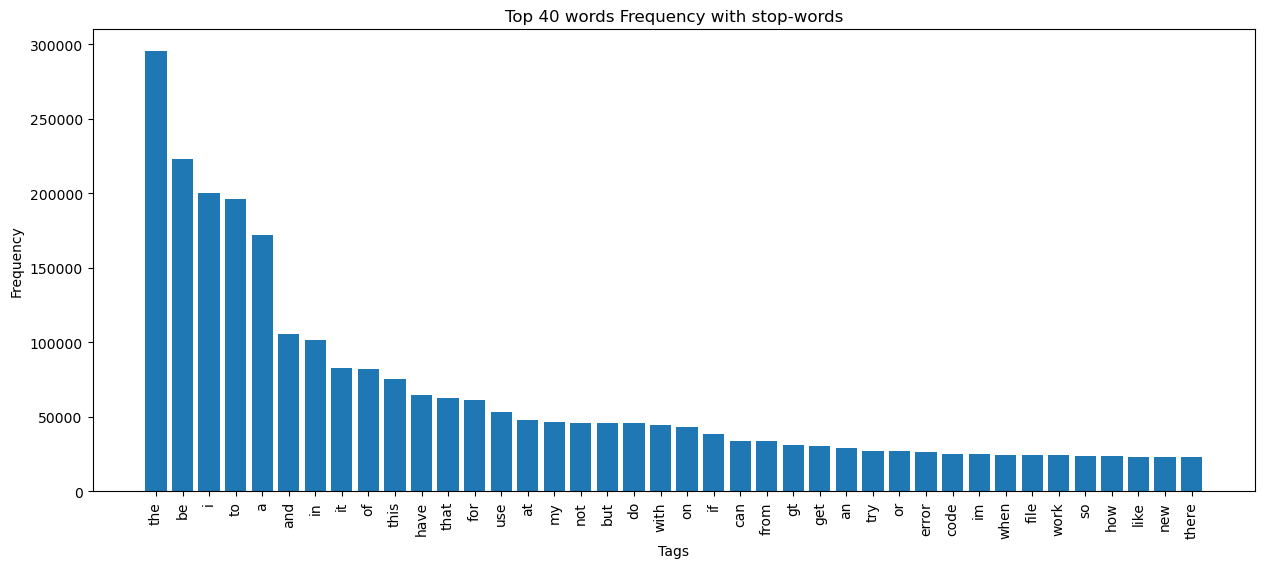

In [118]:
# Get the top 40 of words and their frequencies
token_frequency = calculate_token_frequency(preprocessed_body)
top_40_tags = list(token_frequency.keys())[:40]
top_40_frequencies = list(token_frequency.values())[:40]

# Plot the tags frequency
plt.figure(figsize=(15, 6))
plt.bar(top_40_tags, top_40_frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 40 words Frequency with stop-words')
plt.xticks(rotation=90)
plt.show()

Les mots que l'on retrouve le plus sont des stopword.

In [119]:
preprocessed_body = pipeline.named_steps['stop_words'].transform(preprocessed_body)
print('stop words done')
print(preprocessed_body[0])

stop words done
['android', 'jetpack', 'navigation', 'bottomnavigationview', 'auto', 'fragment', 'back', 'stack', 'back', 'button', 'click', 'choose', 'multiple', 'tab', 'another', 'user', 'user', 'click', 'back', 'button', 'app', 'must', 'redirect', 'last', 'page', 'heshe', 'open', 'achieve', 'android', 'viewpager', 'save', 'currently', 'select', 'item', 'arraylist', 'auto', 'back', 'stack', 'android', 'jetpack', 'navigation', 'release', 'achieve', 'navigation', 'graph', 'activitymainxml', 'ltxml', 'version', 'encodingutfgt', 'ltandroidsupportconstraintconstraintlayout', 'xmlnsandroidhttpschemasandroidcomapkresandroid', 'xmlnsapphttpschemasandroidcomapkresauto', 'xmlnstoolshttpschemasandroidcomtools', 'androidididcontainer', 'androidlayoutwidthmatchparent', 'androidlayoutheightmatchparent', 'toolscontextmainmainactivitygt', 'ltfragment', 'androidididmynavhostfragment', 'androidnameandroidxnavigationfragmentnavhostfragment', 'androidlayoutwidthmatchparent', 'androidlayoutheightdp', 'ap

In [120]:
token_body_frequency = calculate_token_frequency(preprocessed_body)

# Get the top 40 words and their frequencies
top_50_words = list(token_body_frequency.keys())[:40]
top_50_frequencies = list(token_body_frequency.values())[:40]

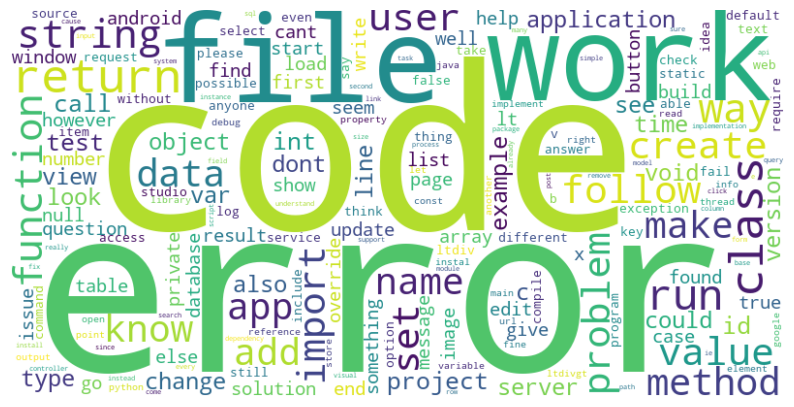

In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Créer l'objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Générer le nuage de mots à partir du dictionnaire de fréquences
wordcloud.generate_from_frequencies(token_body_frequency)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Title preprocessing

In [122]:
title = df.iloc[:].Title

# Appliquer toutes les étapes du pipeline sauf la dernière
preprocessed_title = pipeline[:-1].transform(title)

In [123]:
# Title tokens frequency
token_title_frequency = calculate_token_frequency(preprocessed_title)
print(token_title_frequency)


# Get the top 40 words and their frequencies
top_50_words = list(token_title_frequency.keys())[:40]
top_50_frequencies = list(token_title_frequency.values())[:40]

{'how': 10228, 'i': 3412, 'error': 2842, 'android': 2680, 'file': 2094, 'c': 1861, 'what': 1605, 'be': 1578, 'java': 1509, 'work': 1493, 'studio': 1492, 'value': 1343, 'python': 1307, 'function': 1256, 'code': 1242, 'javascript': 1233, 'v': 1232, 'why': 1226, 'array': 1211, 'string': 1185, 'object': 1164, 'change': 1134, 'server': 1109, 'set': 1086, 'data': 1073, 'way': 1041, 'class': 1035, 'app': 1035, 'sql': 1018, 'create': 994, 'test': 993, 'visual': 979, 'window': 979, 'find': 967, 'add': 960, 'can': 953, 'run': 942, 'google': 928, 'application': 912, 'method': 895, 'database': 880, 'image': 879, 'list': 858, 'type': 856, 'get': 850, 'name': 848, 'fail': 809, 'variable': 779, 'view': 777, 'load': 772, 'io': 766, 'jquery': 761, 'call': 753, 'multiple': 750, 'make': 749, 'without': 742, 'aspnet': 740, 'project': 738, 'text': 719, 'return': 701, 'web': 694, 'button': 687, 'user': 675, 'bootstrap': 672, 'number': 667, 'element': 667, 'table': 656, 'show': 654, 'key': 645, 'api': 640, '

### Tags Preprocessing

In [124]:

tags = df.iloc[:].Tags
preprocessed_tags = pipeline.named_steps['tags_cleaner'].transform(tags)
print(preprocessed_tags)

[['android', 'android-architecture-components', 'bottomnavigationview', 'android-navigation', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-compose-textfield', 'android-compose-button', 'android-jetpack-compose-button'], ['android-architecture-components', 'android-architecture-navigation', 'android-navigation', 'android-jetpack-navigation'], ['android', 'android-jetpack', 'android-jetpack-compose', 'android-jetpack-navigation', 'android-jetpack-compose-scaffold'], ['android', 'android-recyclerview', 'android-jetpack-compose', 'android-jetpack-compose-list', 'android-compose-lazyfor'], ['kotlin', 'android-jetpack-compose', 'android-jetpack', 'android-architecture-navigation', 'jetpack-compose-navigation'], ['android', 'android-fragments', 'android-architecture-components', 'fragmentmanager', 'android-architecture-navigation'], ['android', 'android-jetpack-compose', 'android-jetpack', 'android-jetpack-compose-material3', 'android-compose-appbar'], [

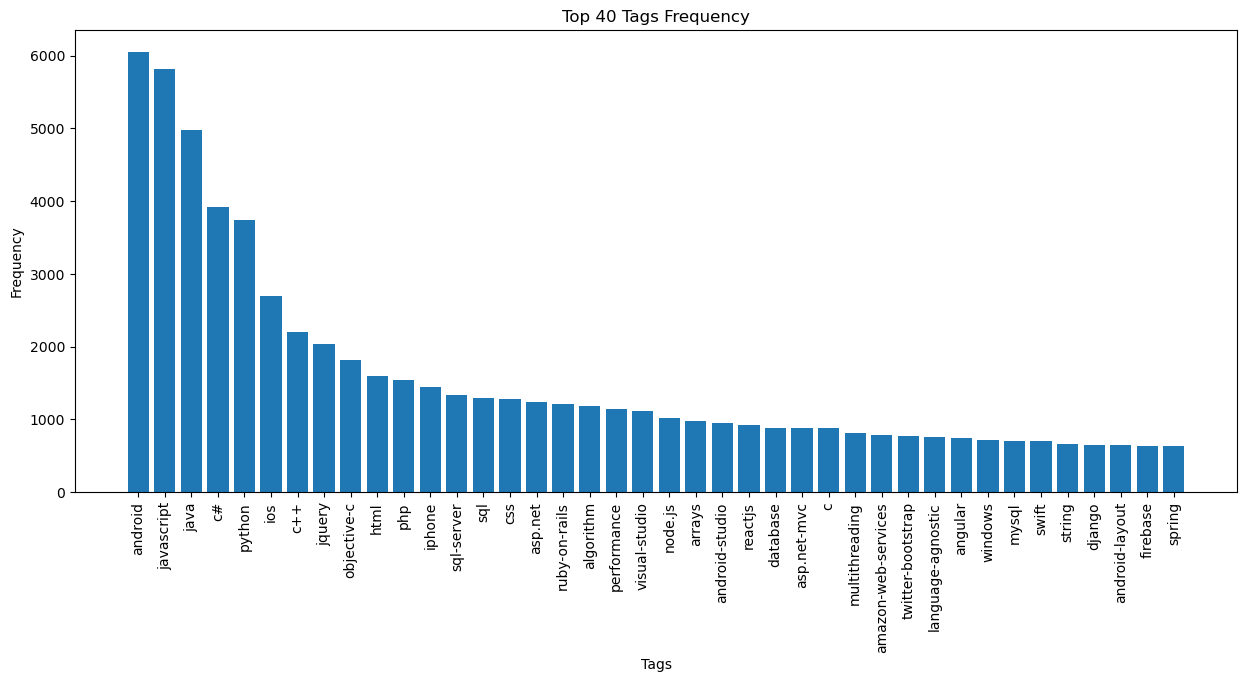

In [125]:
# Tags frequency
tags_frequency = calculate_token_frequency(preprocessed_tags)

# Get the top 40 tags and their frequencies
top_40_tags = list(tags_frequency.keys())[:40]
top_40_frequencies = list(tags_frequency.values())[:40]

# Plot the tags frequency
plt.figure(figsize=(15, 6))
plt.bar(top_40_tags, top_40_frequencies)
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 40 Tags Frequency')
plt.xticks(rotation=90)
plt.show()


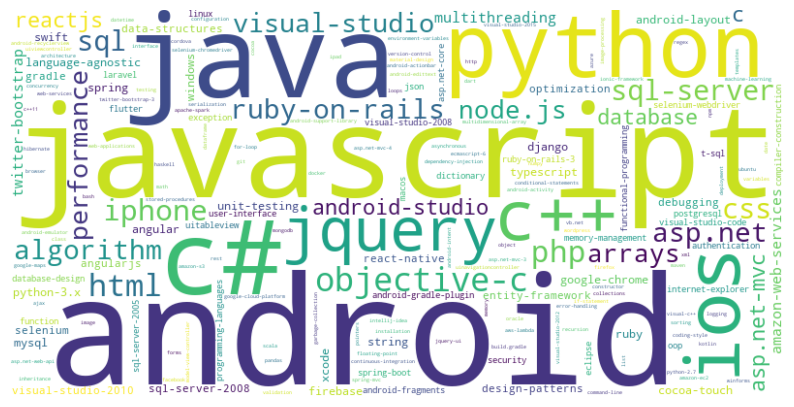

In [126]:
# Créer l'objet WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Générer le nuage de mots à partir du dictionnaire de fréquences
wordcloud.generate_from_frequencies(tags_frequency)

# Afficher le nuage de mots
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [127]:

lonely_tags = [tag for tag, frequency in tags_frequency.items() if frequency == 1]
print("Lonely tags: ",len(lonely_tags))
print("Total_tags:", len(tags_frequency))

Lonely tags:  6264
Total_tags: 15546


In [128]:
# For each sublist, join its elements into a single string
preprocessed_body = [' '.join(sublist) for sublist in preprocessed_body]
preprocessed_title = [' '.join(sublist) for sublist in preprocessed_title]
preprocessed_tags = [' '.join(sublist) for sublist in preprocessed_tags]

# Convert the lists into DataFrames
df_body = pd.DataFrame(preprocessed_body, columns=['Body'])
df_title = pd.DataFrame(preprocessed_title, columns=['Title'])
df_tags = pd.DataFrame(preprocessed_tags, columns=['Tags'])

# Join the DataFrames
df = pd.concat([df_title, df_body, df_tags], axis=1)
display(df.head())

Title  \
0  android jetpack navigation bottomnavigationvie...   
1                    jetpack compose button drawable   
2  how handle back button start destination navig...   
3        topappbar flash navigate compose navigation   
4           how create recycler view compose jetpack   

                                                Body  \
0  android jetpack navigation bottomnavigationvie...   
1  achieve jetpack compose something button eleva...   
2  start work navigation component really dig iss...   
3  screen scaffold topappbar navigate jetpack nav...   
4  special way create recyclerview compose jetpac...   

                                                Tags  
0  android android-architecture-components bottom...  
1  android android-jetpack-compose android-compos...  
2  android-architecture-components android-archit...  
3  android android-jetpack android-jetpack-compos...  
4  android android-recyclerview android-jetpack-c...

### Body exploration

La longueur moyenne des questions en nombre de mots est de 80.26.
le nombre total de mots : 4012780
The number of unique words in df['Body'] is: 385365


<Axes: xlabel='Body_word_count', ylabel='Count'>

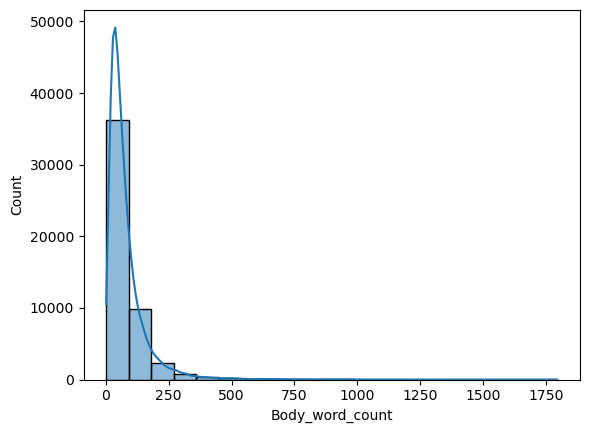

In [129]:
# Appliquer la fonction à la colonne 'Body' du jeu de données
df['Body_word_count'] = df['Body'].apply(count_words)

# Calculer la longueur moyenne des questions en nombre de mots
mean_word_count = df['Body_word_count'].mean()

# Nombre de mots et nombre de mots uniques dans body
unique_words_count = len(set(' '.join(df['Body']).split()))
total_word_count = df['Body_word_count'].sum() 

print(f"La longueur moyenne des questions en nombre de mots est de {mean_word_count:.2f}.")
print("le nombre total de mots :",total_word_count)
print("The number of unique words in df['Body'] is:", unique_words_count)

sns.histplot(df['Body_word_count'], kde=True, bins=20)



In [130]:
import plotly.express as px

px.box(df['Body_word_count'])

Looking for lines with body size < 3   

In [131]:
df_0_word = df[df['Body_word_count'] < 3]
print("Number of questions with less than 3 words:", df_0_word.shape[0])
display("Number of questions with less than 3 words:", df_0_word)

Number of questions with less than 3 words: 12


'Number of questions with less than 3 words:'

Title  \
442                                        what typesafe   
1569                                      why faster php   
4045                         when i threadlocal variable   
8852                be way make tradiobutton transparent   
14646                               when mutex semaphore   
17832                            what metaclasses python   
20143                            what httphandler aspnet   
26432             can global constant declare javascript   
42908                                                      
43644                               what smart pointer i   
46227  be necessary override operator override equal ...   
47038                    php expect tpaamayimnekudotayim   

                              Body  \
442                  typesafe mean   
1569                    faster php   
4045          threadlocal variable   
8852                        delphi   
14646              mutex semaphore   
17832                  metaclasses   
20143           httphandler aspnet   
26432           syntax declaration   
42908          multiply javascript   
43644                smart pointer   
46227                    advisable   
47038  anyone tpaamayimnekudotayim   

                                                    Tags  Body_word_count  
442    language-agnostic programming-languages comput...                2  
1569   php operators comparison-operators equality-op...                2  
4045   java multithreading concurrency thread-local t...                2  
8852   delphi radio-button transparency delphi-2010 t...                1  
14646  linux multithreading synchronization mutex sem...                2  
17832  python oop metaclass python-class python-datam...                1  
20143  asp.net httphandler ihttphandler ihttpasynchan...                2  
26432    javascript variables constants global-variables                2  
42908        javascript floating-point floating-accuracy                2  
43644          c++ pointers c++11 smart-pointers c++-faq                2  
46227               operators overriding equals-operator                1  
47038          php runtime-error syntax-error error-code                2

In [132]:
# Remove the questions with less than 3 words
df = df[df['Body_word_count'] > 2]

error          26497
code           25129
file           24569
work           24097
return         20757
class          20110
run            16344
way            14944
function       14481
string         14271
set            13569
follow         13462
import         13242
user           13234
create         13124
value          13105
problem        13008
method         12627
data           12315
name           11998
make           11836
add            11552
app            11317
know           11291
project        11102
test           11059
id             10950
call           10909
int            10769
application    10760
time           10566
version        10335
also           10304
see            10026
change          9985
object          9970
void            9968
c               9595
type            9509
look            9426
example         9228
view            9147
dont            9064
server          9027
line            9004
could           8880
var             8800
question     

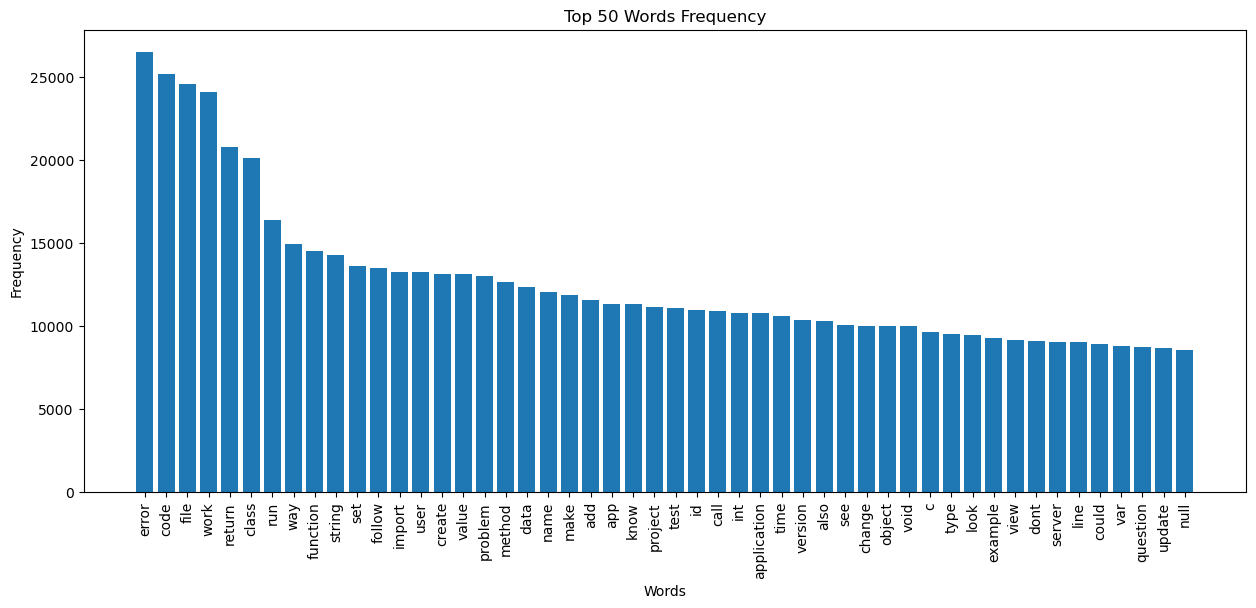

In [133]:
# word frequency
top_50_words = df['Body'].str.split(expand=True).stack().value_counts()[:50]
print(top_50_words)

# Plot the top 50 words frequency
plt.figure(figsize=(15, 6))
plt.bar(top_50_words.index, top_50_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words Frequency')
plt.xticks(rotation=90)
plt.show()


In [134]:
# word frequency
flop_30_words = df['Body'].str.split(expand=True).stack().value_counts()[30:]
print(flop_30_words)


# Plot the top 50 words frequency
'''plt.figure(figsize=(15, 6))
plt.bar(flop_30_words.index, flop_30_words.values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('flop 50 Words Frequency')
plt.xticks(rotation=90)
plt.show()'''

time                                                                                 10566
version                                                                              10335
also                                                                                 10304
see                                                                                  10026
change                                                                                9985
                                                                                     ...  
pivottable                                                                               1
checkdetect                                                                              1
vspackage                                                                                1
appitembackgroundcolortransparent                                                        1
orgeclipsejettyservershutdownmonitorshutdownmonitorrunnablerunshutdownmonitorjava        1

"plt.figure(figsize=(15, 6))\nplt.bar(flop_30_words.index, flop_30_words.values)\nplt.xlabel('Words')\nplt.ylabel('Frequency')\nplt.title('flop 50 Words Frequency')\nplt.xticks(rotation=90)\nplt.show()"

In [135]:
#garder un nombre de tags limité, on va garder les 20 tags les plus fréquents
tags_to_keep = list(pd.Series(tags_frequency).sort_values(ascending=False).iloc[:20].index)
print(tags_to_keep)

['android', 'javascript', 'java', 'c#', 'python', 'ios', 'c++', 'jquery', 'objective-c', 'html', 'php', 'iphone', 'sql-server', 'sql', 'css', 'asp.net', 'ruby-on-rails', 'algorithm', 'performance', 'visual-studio']


In [136]:
# Supprimer les ligne ou aucun tags ne sont pas dans tags_to_keep
df_tags_filtered = df[df['Tags'].apply(lambda x: any(tag in tags_to_keep for tag in x.split()))]
df_tags_filtered.shape
display(df_tags_filtered.head(), df_tags_filtered.shape)

Title  \
0  android jetpack navigation bottomnavigationvie...   
1                    jetpack compose button drawable   
3        topappbar flash navigate compose navigation   
4           how create recycler view compose jetpack   
6                                how navhostfragment   

                                                Body  \
0  android jetpack navigation bottomnavigationvie...   
1  achieve jetpack compose something button eleva...   
3  screen scaffold topappbar navigate jetpack nav...   
4  special way create recyclerview compose jetpac...   
6  integrate android navigation architecture comp...   

                                                Tags  Body_word_count  
0  android android-architecture-components bottom...              131  
1  android android-jetpack-compose android-compos...               60  
3  android android-jetpack android-jetpack-compos...              198  
4  android android-recyclerview android-jetpack-c...                7  
6  android android-fragments android-architecture...               48

(36819, 4)

In [137]:
display(df_tags_filtered)

df_tags_filtered.to_csv('Data/df_tags_filtered.csv', index=False)

Title  \
0      android jetpack navigation bottomnavigationvie...   
1                        jetpack compose button drawable   
3            topappbar flash navigate compose navigation   
4               how create recycler view compose jetpack   
6                                    how navhostfragment   
...                                                  ...   
49995  spring rest json can handle managedback refere...   
49996              disableenable submit button form fill   
49997                       how keep net console app run   
49998             how avoid javalangnoclassdeffounderror   
49999  jetty throw noclassdeffounderror orgeclipsejet...   

                                                    Body  \
0      android jetpack navigation bottomnavigationvie...   
1      achieve jetpack compose something button eleva...   
3      screen scaffold topappbar navigate jetpack nav...   
4      special way create recyclerview compose jetpac...   
6      integrate android navigation architecture comp...   
...                                                  ...   
49995  post httplocalhosttranslators angularjs fronte...   
49996  form submit button disabledenabled depend form...   
49997  consider console application start service sep...   
49998  code add text exist doc file itll save another...   
49999  maven build throw end build shutdown jetty noc...   

                                                    Tags  Body_word_count  
0      android android-architecture-components bottom...              131  
1      android android-jetpack-compose android-compos...               60  
3      android android-jetpack android-jetpack-compos...              198  
4      android android-recyclerview android-jetpack-c...                7  
6      android android-fragments android-architecture...               48  
...                                                  ...              ...  
49995            java json hibernate jackson spring-boot              273  
49996           javascript forms submit disabled-control               56  
49997           c# multithreading sleep manualresetevent               53  
49998           java apache-poi noclassdeffounderror doc              165  
49999           java jetty noclassdeffounderror shutdown              290  

[36819 rows x 4 columns]

<Axes: >

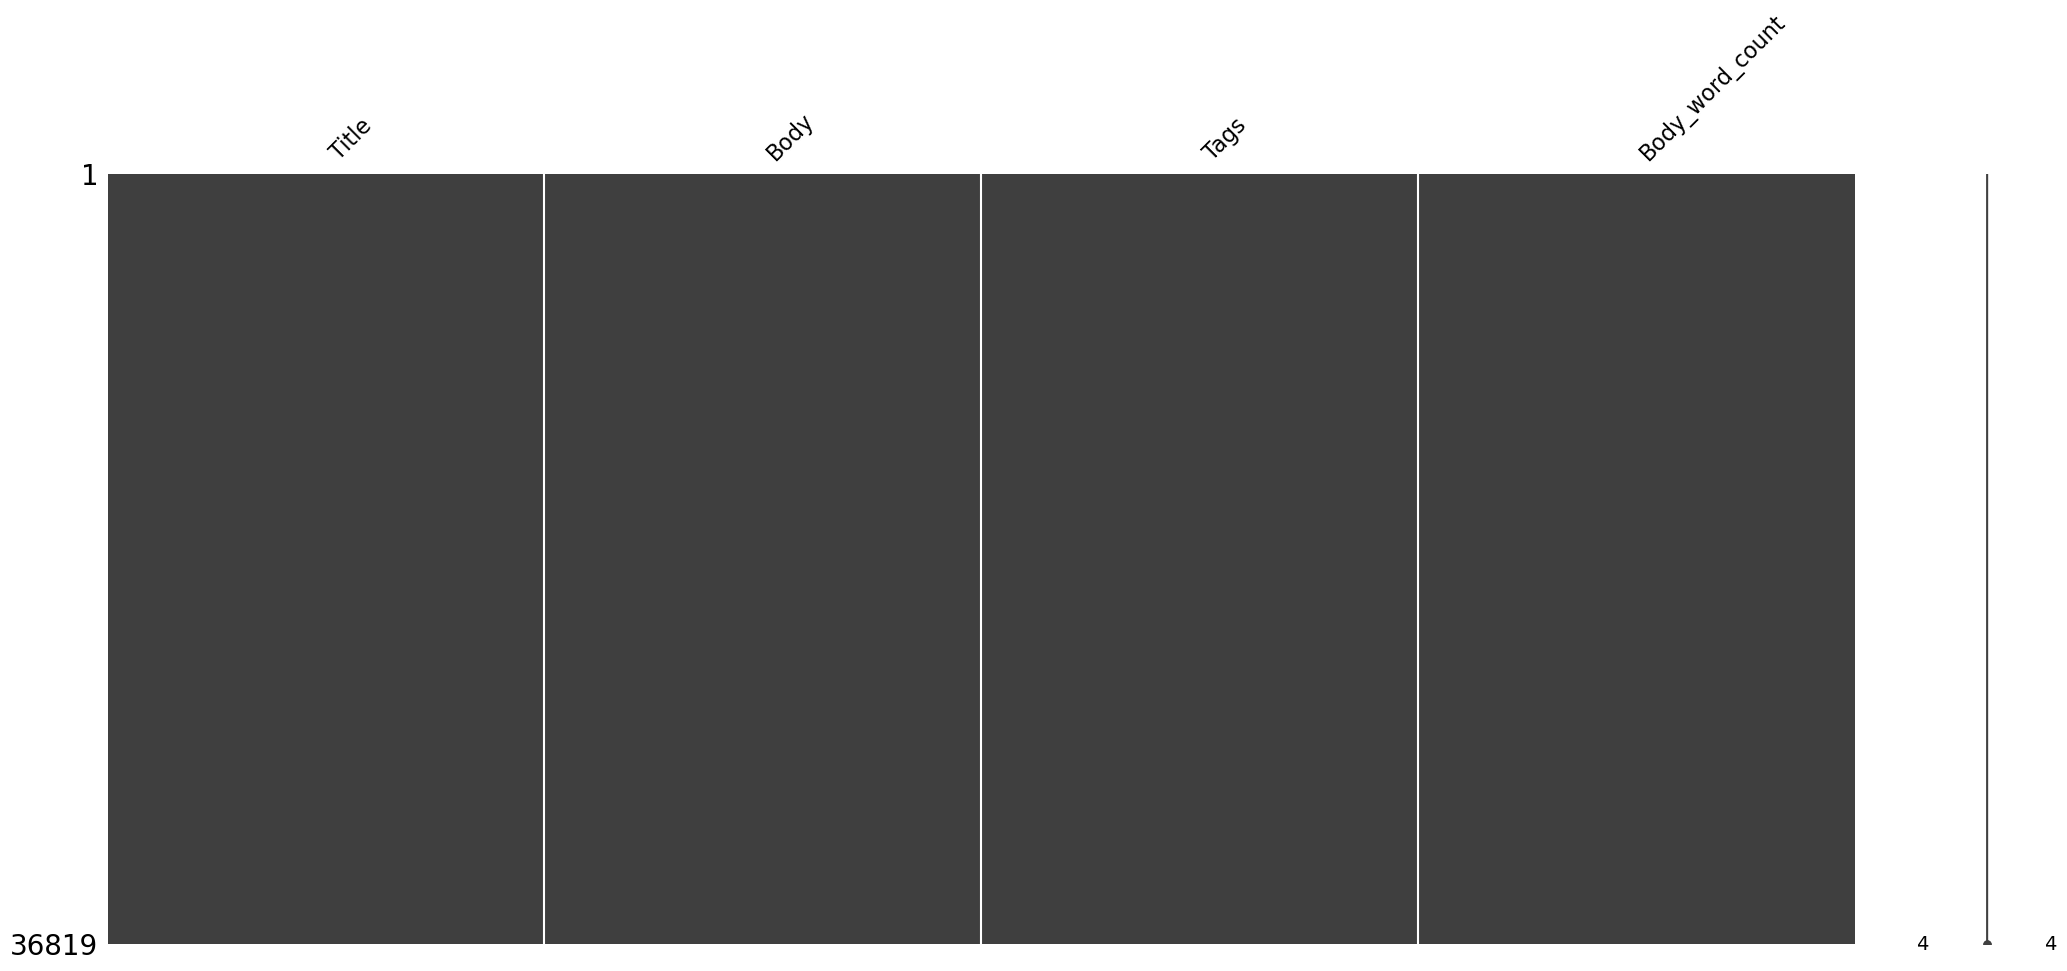

In [138]:
msno.matrix(df_tags_filtered)

## Vectorization Bag of words 
Le "bag of words" est une méthode de représentation de texte sous forme de vecteur numérique. Elle consiste à compter l'occurrence de chaque mot dans le texte, en ignorant leur ordre et leur grammaire. Le résultat est un vecteur où chaque dimension correspond à un mot unique dans le corpus. Cette méthode est largement utilisée  pour représenter des données textuelles.

In [139]:
class CustomCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer(min_df=0.01)

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)

pipeline_vec = Pipeline([
    ("count_vectorizer", CustomCountVectorizer())
])

In [140]:
X_body = df['Body']
X_body_vectorized =pipeline_vec.named_steps['count_vectorizer'].fit_transform(X_body)

print(X_body_vectorized.shape)

(49988, 820)


In [141]:
#Obtenir la liste des mots du vocabulaire

vocab = pipeline_vec.named_steps['count_vectorizer'].vectorizer.get_feature_names_out()
# Extraire la première ligne de X_body
first_row = X_body_vectorized[0]

# Convertir la première ligne en un dictionnaire avec les mots comme clés et les valeurs comme valeurs
first_row_dict = {vocab[i]: first_row[0, i] for i in range(len(vocab))}

# Créer un DataFrame à partir du dictionnaire
df_first_row = pd.DataFrame([first_row_dict])

display(df_first_row)
# Filtrer le DataFrame pour inclure uniquement les colonnes avec des valeurs non nulles
df_first_row_filtered = df_first_row.loc[:, df_first_row.sum() > 0]

# Afficher le DataFrame filtré
display(df_first_row_filtered) 

able  accept  access  accord  account  achieve  across  action  active  \
0     0       0       0       0        0        2       0       0       0   

   activity  ...  work  world  write  wrong  xcode  xml  \
0         0  ...     0      0      0      0      0    0   

   xmlnsandroidhttpschemasandroidcomapkresandroid  year  yes  yet  
0                                               1     0    0    0  

[1 rows x 820 columns]

achieve  add  also  android  androidlayoutheightwrapcontent  \
0        2    1     1        3                               1   

   androidlayoutwidthmatchparent  another  answer  app  back  ...  proper  \
0                              2        1       1    1     5  ...       1   

   provide  release  save  select  stack  tab  user  version  \
0        1        1     1       1      2    1     2        2   

   xmlnsandroidhttpschemasandroidcomapkresandroid  
0                                               1  

[1 rows x 38 columns]

In [142]:
freqw = X_body_vectorized.sum(axis=0)
frequent_words = pd.Series(freqw.tolist()[0], index=pipeline_vec.named_steps['count_vectorizer'].vectorizer.get_feature_names_out())
print(frequent_words.sort_values(ascending=False)[:5])

error     26497
code      25129
file      24569
work      24097
return    20757
dtype: int64


In [143]:
X_train, X_test, y_train, y_test = train_test_split(df_tags_filtered[["Body", "Title"]],
    df_tags_filtered[['Tags']],
    test_size=0.2,
    random_state=42
)
display(X_train.head(), X_test.head(), y_train.head(), y_test.head())

Body  \
9653   jqueryjavascript newbie add class open accordi...   
4317   reading empty base optimizationebo reading fol...   
43512  way initialize java hashmap mapltstringstringg...   
32252  various string format method python lt quothel...   
24848  option jquery ui datepicker open datepicker bu...   

                                                  Title  
9653   twitter bootstrap add class open accordion title  
4317        when programmer empty base optimization ebo  
43512       how directly initialize hashmap literal way  
32252          string format v format v fstring literal  
24848            disable set focus jquery ui datepicker

Body  \
16943  wonder completely eventdrive framework php bas...   
21299  sample file ltdoctype htmlgt lthtmlgt ltheadgt...   
49261  dont know anymore hopeless tire guess whats ca...   
34284  controller httppost jsonresult findstuffstring...   
47687  know compare member function lt operator cant ...   

                                               Title  
16943                      eventdriven php framework  
21299            e import work even toplevel firefox  
49261            how debug properly find cause crash  
34284  how unit test action method return jsonresult  
47687             in way member function may compare

Tags
9653   javascript jquery jquery-ui twitter-bootstrap ...
4317   c++ class optimization memory-management compi...
43512         java dictionary collections initialization
32252      python performance string-formatting f-string
24848   jquery mobile jquery-mobile jquery-ui-datepicker

Tags
16943  php design-patterns frameworks dependency-inje...
21299   javascript html firefox ecmascript-6 es6-modules
49261           c++ visual-studio-2008 opengl windows-xp
34284        c# asp.net-mvc json unit-testing jsonresult
47687          c++ function operator-overloading compare

In [144]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

X_train = pd.DataFrame(X_train, columns=["Body", "Title"])
X_test = pd.DataFrame(X_test, columns=["Body", "Title"])
y_train = pd.DataFrame(y_train, columns=["Tags"])
y_test = pd.DataFrame(y_test, columns=["Tags"])

(29455, 2)
(29455, 1)
(7364, 2)
(7364, 1)


In [145]:
print(X_train.head(), X_test.head(), y_train.head(), y_test.head())

                                                    Body  \
9653   jqueryjavascript newbie add class open accordi...   
4317   reading empty base optimizationebo reading fol...   
43512  way initialize java hashmap mapltstringstringg...   
32252  various string format method python lt quothel...   
24848  option jquery ui datepicker open datepicker bu...   

                                                  Title  
9653   twitter bootstrap add class open accordion title  
4317        when programmer empty base optimization ebo  
43512       how directly initialize hashmap literal way  
32252          string format v format v fstring literal  
24848            disable set focus jquery ui datepicker                                                       Body  \
16943  wonder completely eventdrive framework php bas...   
21299  sample file ltdoctype htmlgt lthtmlgt ltheadgt...   
49261  dont know anymore hopeless tire guess whats ca...   
34284  controller httppost jsonresult findstuffstri

## preprocessing du fichier visant a tester la stabilité du modele

In [146]:
data_stab = pd.read_csv('Data/QueryResults_stability.csv')
pipeline_stab = Pipeline([ 
    ('html_cleaner', HtmlCleaner()),
    ('tokenizer', TextTokenizer()),
    ('stop_words', TextStopWordRemover()),
    ('text_lower', TextLower()),
    ('lemmatizer',TextLemmatizer())
])

body = data_stab['Body']
title = data_stab['Title']
tags = data_stab['Tags']
body_stab = pipeline_stab.transform(body)

In [147]:
title_stab = pipeline_stab.transform(title)
tags_stab = pipeline.named_steps['tags_cleaner'].transform(tags)
date = data_stab['CreationDate']
body_stab = [' '.join(sublist) for sublist in body_stab]
title_stab = [' '.join(sublist) for sublist in title_stab]
tags_stab = [' '.join(sublist) for sublist in tags_stab]

df_stab = pd.DataFrame({'Body': body_stab, 'Title': title_stab, 'Tags': tags_stab, 'CreationDate': date})

# Join the DataFrames
df = pd.concat([df_stab], axis=1)
tags_frequency = calculate_token_frequency(preprocessed_tags)
tags_to_keep = list(pd.Series(tags_frequency).sort_values(ascending=False).iloc[:20].index)
df_stab = df[df['Tags'].apply(lambda tags: any(tag in tags_to_keep for tag in tags))]
df_stab.shape

df_stab.to_csv('Data/df_stab.csv', index=False)